## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dirty_completeness

## Useful Functions

In [ ]:
def hists_plot(df):
    fig, axes = plt.subplots(1, len(df.columns), figsize=(20,5))
    ax = axes.flatten()
    for i, col in enumerate(df.columns):
        sns.countplot(df, x=col, ax=axes[i], order=sorted(df[col].value_counts().index))

In [ ]:
def accuracy(df, df_imputed):
    accuracy = {}
    for col in df.columns:
        equal = np.where(df[col] == df_imputed[col], True, False)
        accuracy[col] = equal[equal == True].sum() / len(equal)
    return accuracy

In [ ]:
def jaccard_dist(a,b):
    intersction =len(set(a).intersection(b))
    union = len(a) + len(b) -intersction
    return 1 - float(intersction) / union

## Read data

In [ ]:
users = pd.read_csv('users.csv')

In [ ]:
hists_plot(users)

## Shuffle data

In [ ]:
users = users.sample(frac=1, axis=0).reset_index(drop=True)

## Inject null values

In [ ]:
users_dirty = np.array(dirty_completeness.injection(df_pandas=users, seed=1234, name = 'users', name_class="none"))

In [ ]:
users_dirty = users_dirty[0,:,:] #50% completeness

In [ ]:
users_dirty = pd.DataFrame(users_dirty,columns=users.columns)

In [ ]:
users_dirty

## Visualizing null values

In [ ]:
sns.heatmap(users_dirty.isna())

## Simple Imputation

In [ ]:
users_simple_imp = users_dirty.fillna(method='ffill')
users_simple_imp.isna().count()
users_simple_imp = users_simple_imp.fillna(method='bfill')

In [ ]:
hists_plot(users)
hists_plot(users_dirty)
hists_plot(users_simple_imp)

In [ ]:
accuracy(users, users_simple_imp)

## Advanced Imputation

In [ ]:
users_dirty_one_hot = pd.get_dummies(users_dirty)
for col in users_dirty.columns:
    users_dirty_one_hot.loc[users_dirty[col].isnull(), users_dirty_one_hot.columns.str.startswith(col)] = np.nan

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
knn_imputer = KNNImputer(n_neighbors=4)
users_knn_imp_one_hot = pd.DataFrame(knn_imputer.fit_transform(users_dirty_one_hot))
users_knn_imp_one_hot.columns = users_dirty_one_hot.columns

In [ ]:
users_knn_imp = pd.DataFrame()
for col in users_dirty.columns:
   users_knn_imp[col] = users_knn_imp_one_hot.loc[:, users_knn_imp_one_hot.columns.str.startswith(col)].idxmax(1)
users_knn_imp = users_knn_imp.apply(lambda e: e.str[3:] )

In [ ]:
hists_plot(users)
hists_plot(users_knn_imp)

In [ ]:
accuracy(users,users_knn_imp)

## Clustering

Because of the categorical nature of the dataset, KModes is performed

In [ ]:
%pip install kmodes

In [ ]:
from kmodes.kmodes import KModes

In [ ]:
# Elbow curve to find optimal K
cost = []
K = range(1,15)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(users_knn_imp)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()


According to the elbow plot we get the optimal number of cluster k=5

In [ ]:
kmodes = KModes(n_jobs = -1, n_clusters = 5, init = 'random', random_state = 0)
kmodes.fit_predict(users_knn_imp)

In [ ]:
users_knn_imp['Cluster'] = kmodes.labels_

In [ ]:
users_knn_imp

## Agglomerative Hierarchical Clustering

In [83]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances

In [149]:
dist_matrix = np.zeros((len(users), len(users)))

In [150]:
for i, u in enumerate(users.iterrows()):
    for j, w in enumerate(users.iterrows()):
        dist_matrix[i,j] = jaccard_dist(users.loc[i],users.loc[j])

In [164]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='precomputed',linkage='complete').fit(dist_matrix)

In [165]:
from scipy.cluster.hierarchy import dendrogram

In [166]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

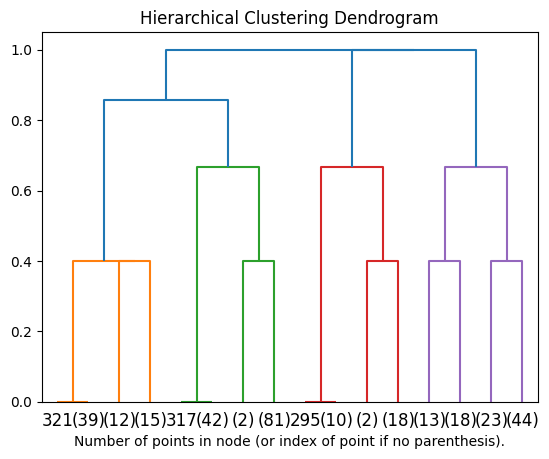

In [167]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()